In [ ]:
import os
import re
import scipy.io as sio

mat_file = r'C:\Users\mattt\Skripsie\Projects\DTW-project\data\processed\u1001\GlobalFeatures\u1001s0001_sg0001.mat'

# 1) filename → genuine vs forgery
fname = os.path.basename(mat_file)
m = re.match(r'u(\d{4})s(\d{4})_sg(\d{4})\.mat', fname)
if m:
    user, session, sample = m.groups()
    sample = int(sample)
    genuines = {1, 2, 6, 7}
    label = "genuine" if sample in genuines else "skilled forgery"
    print(f"User {user}, session {session}, sample {sample:04d} → {label}\n")
else:
    print("⚠️ Filename didn’t match expected pattern\n")

try:
    mat = sio.loadmat(mat_file, squeeze_me=True, struct_as_record=False)
    print("Loaded with scipy.io.loadmat\n")

    for name, data in mat.items():
        if name.startswith("__"):
            continue

        # --- info printout ---
        shape = getattr(data, "shape", None)
        dtype = getattr(data, "dtype", None)
        info = [f"type={type(data).__name__}"]
        if shape is not None:
            info.append(f"shape={shape}")
        if dtype is not None:
            info.append(f"dtype={dtype}")
        print(f"Variable `{name}`: " + ", ".join(info))

        # --- look for any stored headings ---
        headings = None
        if hasattr(data, "_fieldnames"):
            headings = data._fieldnames
        elif hasattr(data, "dtype") and data.dtype.names:
            headings = data.dtype.names

        if headings:
            print("Headings:")
            for h in headings:
                print(f"  • {h}")
        else:
            print("No heading names stored (just raw numeric array).")

        # --- print the actual values ---
        print("Data:")
        print(data)
        print("-" * 40)

except FileNotFoundError:
    print("File not found—please check the path.")


User 1001, session 0001, sample 0001 → genuine

Loaded with scipy.io.loadmat

Variable `globalFeatures`: type=ndarray, shape=(40,), dtype=float64
No heading names stored (just raw numeric array).
Data:
[0.49795 0.50036 0.49531 0.49521 0.50643 0.49331 0.5019  0.50435 0.5051
 0.50592 0.5013  0.49842 0.50375 0.4946  0.49721 0.49481 0.49683 0.5081
 0.50662 0.50199 0.49881 0.50143 0.50846 0.50128 0.50906 0.49839 0.49701
 0.49255 0.50521 0.50544 0.49574 0.50276 0.50541 0.49614 0.49759 0.50879
 0.49896 0.49794 0.5023  0.50061]
----------------------------------------


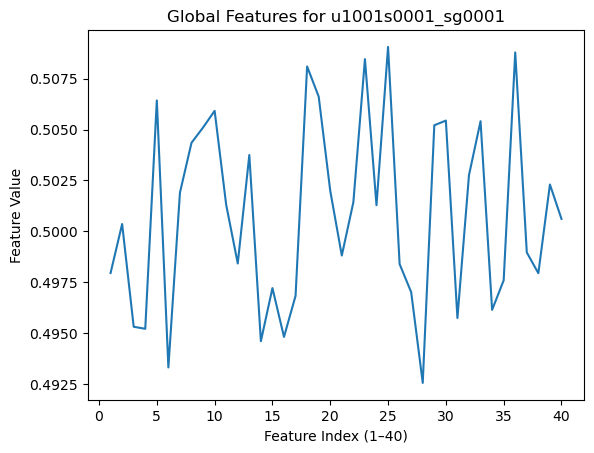

In [14]:
import scipy.io as sio
import matplotlib.pyplot as plt
from pathlib import Path

# ── Adjust this if your notebook isn’t at project_root/notebooks ──
project_root = Path().cwd().parent  

# Build the path to your .mat
mat_file = project_root / 'data' / 'processed' / 'u1001' / 'GlobalFeatures' / 'u1001s0001_sg0001.mat'

# Load the file
mat = sio.loadmat(mat_file, squeeze_me=True, struct_as_record=False)
data = mat['globalFeatures']  # this is your length‑40 vector

# Plot
plt.figure()
plt.plot(range(1, len(data)+1), data)         # x = feature index 1–40
plt.xlabel('Feature Index (1–40)')
plt.ylabel('Feature Value')
plt.title('Global Features for u1001s0001_sg0001')
plt.show()


C:\Users\mattt\AppData\Local\Temp\ipykernel_11532\3863478503.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=cm.get_cmap(cmap_name),


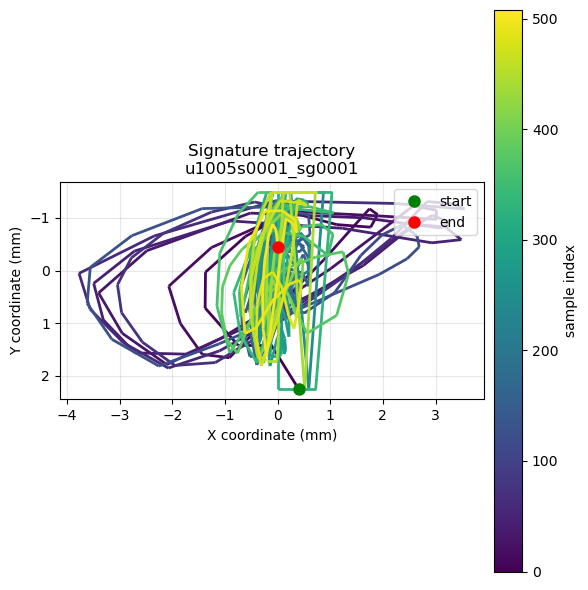

In [41]:
from pathlib import Path
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm


def plot_signature_trajectory(user: int, session: int, sample: int,
                              root=Path.cwd().parent / "data" / "raw" / "LocalFunctions",
                              cmap_name="viridis"):
    """Plot BiosecurID on-line signature with a gradient-coloured path."""
    fname = f"u{user:04d}s{session:04d}_sg{sample:04d}.mat"
    mat_path = root / fname
    if not mat_path.exists():
        raise FileNotFoundError(mat_path)

    # ── load trajectory ──────────────────────────────────────────────
    local = sio.loadmat(mat_path, squeeze_me=True)["localFunctions"]  # (N, 9)
    x, y = local[:, 0], local[:, 1]
    n_pts = len(x)

    # ── build coloured line segments ────────────────────────────────
    points = np.column_stack([x, y])
    segs = np.concatenate([points[:-1, None], points[1:, None]], axis=1)
    lc = LineCollection(segs,
                        cmap=cm.get_cmap(cmap_name),
                        norm=plt.Normalize(0, n_pts - 1))
    lc.set_array(np.arange(n_pts - 1))
    lc.set_linewidth(2)

    # ── plot ────────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.add_collection(lc)

    # start / end markers
    ax.plot(x[0],  y[0],  "go",  markersize=8, label="start")
    ax.plot(x[-1], y[-1], "ro",  markersize=8, label="end")

    ax.set_aspect("equal", adjustable="box")
    ax.invert_yaxis()                       # match writing surface coords
    ax.set_xlabel("X coordinate (mm)")
    ax.set_ylabel("Y coordinate (mm)")
    ax.set_title(f"Signature trajectory\nu{user:04d}s{session:04d}_sg{sample:04d}")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right")
    cbar = fig.colorbar(lc, ax=ax, pad=0.02)
    cbar.set_label("sample index")

    plt.tight_layout()
    plt.show()


# Example
plot_signature_trajectory(user=1005, session=1, sample=1)